In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sciopy import EIT_16_32_64_128, EitMeasurementSetup
import matplotlib.pyplot as plt

In [4]:
# create a 'sciospec' class which represents the sciospec EIT device
n_el =  64
#64 
sciospec = EIT_16_32_64_128(n_el)

In [5]:
# connect device via USB-HS port
sciospec.connect_device_HS()

In [6]:
# read system message buffer
sciospec.SystemMessageCallback()
# should be empty

No message inside the message buffer
message buffer:
 []
message length:	 0


In [7]:
# create a measurement setup
setup = EitMeasurementSetup(
    burst_count=5,
    n_el=n_el,
    exc_freq=125_000,
    framerate=3,
    amplitude=0.01,
    inj_skip=n_el // 2,
    gain=1,
    adc_range=1,
)

In [8]:
sciospec.SetMeasurementSetup(setup)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [9]:
# get data
data = sciospec.StartStopMeasurement(return_as="pot_mat")  # or "hex"  # kommt in for schleife 

In [10]:
data.shape   #mitteln, 1-4 burst count für training, und 5. für test for pot in data:

(5, 64, 64)

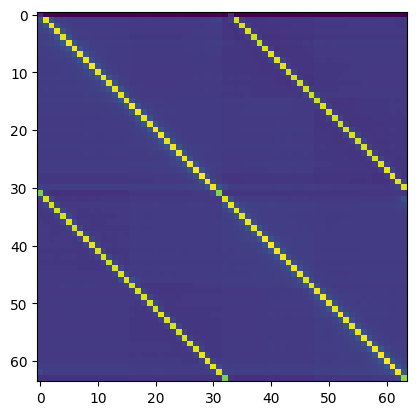

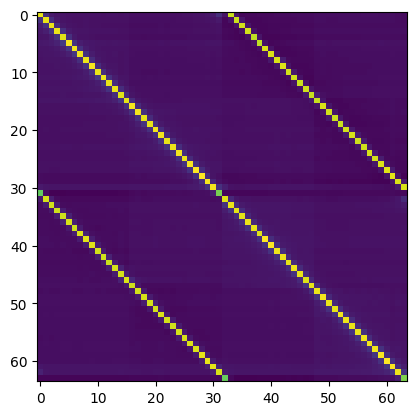

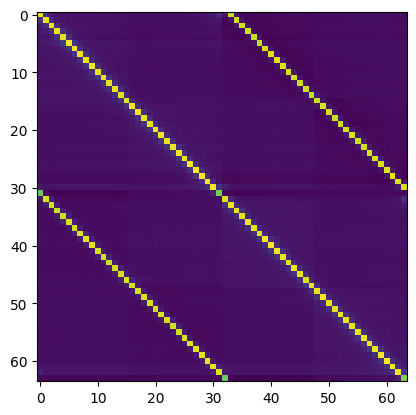

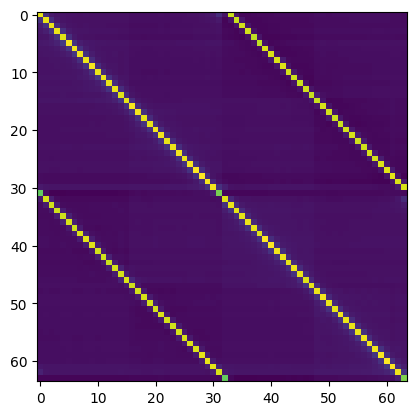

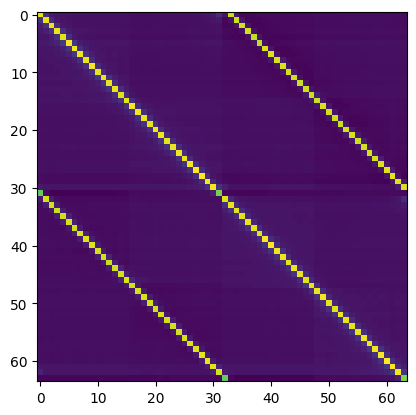

In [11]:
for pot in data:
    plt.imshow(np.abs(pot))
    plt.show()

In [12]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    create_trajectory,
    create_trajectory_3D
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors

def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break

# class
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos

    def move_to_absolute_x_y_z(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} Z{P[2]} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180, P[2]]  #z im Bereich 50 bis 100 mm
        return pos

    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp

In [13]:
printer = EnderControl(com_port="/dev/ttyUSB0")
printer.connect()

Connection to /dev/ttyUSB0 is established.


## Initializing Printer ##

In [14]:
printer.init()

b'start\n'
b'echo: External Reset\n'
b'Marlin Ver 1.70.3 BL\n'
b'\n'
b'echo: Last Updated: 2022-02-24 | Author: Ender-5 Plus\n'
b'echo:Compiled: Feb 24 2022\n'
b'echo: Free Memory: 1406  PlannerBufferBytes: 1232\n'
b'echo:V42 stored settings retrieved (530 bytes; crc 12996)\n'
b'echo:  G21    ; Units in mm\n'
b'echo:  M149 C ; Units in Celsius\n'
b'\n'
b'echo:Filament settings: Disabled\n'
b'echo:  M200 D1.75\n'
b'echo:  M200 D0\n'
b'echo:Steps per unit:\n'
b'echo:  M92 X80.00 Y80.00 Z800.00 E92.60\n'
b'echo:Maximum feedrates (units/s):\n'
b'echo:  M203 X300.00 Y300.00 Z5.00 E25.00\n'
b'echo:Maximum Acceleration (units/s2):\n'
b'echo:  M201 X500 Y500 Z100 E1000\n'
b'echo:Acceleration (units/s2): P<print_accel> R<retract_accel> T<travel_accel>\n'
b'echo:  M204 P500.00 R500.00 T1000.00\n'
b'echo:Advanced: S<min_feedrate> T<min_travel_feedrate> B<min_segment_time_ms> X<max_xy_jerk> Z<max_z_jerk> E<max_e_jerk>\n'
b'echo:  M205 S0.00 T0.00 B20000 X10.00 Y10.00 Z0.40 E5.00\n'
b'echo:Home off

[180, 180]

## Generating and saving data ##

In [21]:
def generate_exp_data(traj, r_path, r_anomaly, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=750):

    #ref_radius = 0.2
    #scale_factor = r_path / ref_radius
    #scaled_points = int(round(base_points * scale_factor))
    #print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    #center_pos = create_trajectory(traj, r_path * 97, scaled_points)  # Trajektorie mit der skalierten Punktzahl
    center_pos = create_trajectory(traj, r_path * 97, base_points)
    base_dataset_folder = "exp_data_set"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    base_name = "exp_data"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": base_points,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")


def generate_exp_data_3D(traj, r_path, r_anomaly, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=1000):
    #ref_radius = 0.5
    #scale_factor = r_path / ref_radius
    #scaled_points = int(round(base_points * scale_factor))
    #print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    fig = plt.figure(figsize=(20, 8))

    n_turns = 3
    
    center_pos = create_trajectory_3D(traj, r_path*97, base_points, n_turns)
    #print(center_pos)
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax1.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax1.view_init(elev=90, azim=0)  # Top view
    ax1.set_title('Top View')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax2.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax2.view_init(elev=0, azim=0)  # Side view
    ax2.set_title('Side View')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax3.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax3.view_init(elev=45, azim=45)  # Isometric view
    ax3.set_title('Isometric View')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    plt.tight_layout()
    for ax in [ax1, ax2, ax3]:
        ax.legend()
    
    plt.show()

    base_dataset_folder = "exp_data_set_3D"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    base_name = "exp_data_3D"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": base_points,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_3D_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    file_path = os.path.join(folder_name, "sample_000000.npz")
    empty_tank_pos = [180, 180, 00]
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y_z(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz") 
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")



import time  

def generate_exp_data_sequential_multiple_trajs(traj_list, r_path_list, r_anomaly_list, material, empty_tank_pos, empty_tank_timestamp, 
                                                 empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=7000, 
                                                 resume=False):
    fig = plt.figure(figsize=(20, 8))

    base_dataset_folder = "exp_data_set_3D"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    base_name = "exp_data_3D"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    lookup = {
        "folder": folder_name,
        "Material": material,
        "Trajectories": []  
    }

    for traj, r_path, r_anomaly in zip(traj_list, r_path_list, r_anomaly_list):
        ref_radius = 0.5
        scale_factor = r_path / ref_radius
        scaled_points = int(round(base_points * scale_factor))
        traj_details = {
            "Trajectory": traj,
            "Radius (r_path)": r_path,
            "Number of Points (Nsteps)": scaled_points,
            "Anomaly Radius (r_anomaly)": r_anomaly
        }
        lookup["Trajectories"].append(traj_details)

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_3D_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)

    start_index = 0
    global_index = 0  
    
    for traj, r_path, r_anomaly in zip(traj_list, r_path_list, r_anomaly_list):
        
        ref_radius = 0.5
        scale_factor = r_path / ref_radius
        scaled_points = int(round(base_points * scale_factor))
        print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
        
        n_turns = 20
        center_pos = create_trajectory_3D(traj, r_path*97, scaled_points, n_turns)
        
        first_position = center_pos[0]  
        pos = printer.move_to_absolute_x_y_z(first_position)  

        # Warte 10 Sekunden, bevor die Messung startet
        print(f"Warte 20 Sekunden bevor die Messung gestartet wird...")
        time.sleep(20)

        
        for save_index, Ps in tqdm(enumerate(center_pos[start_index:], start=start_index), total=len(center_pos)-start_index): 
        
            pos = printer.move_to_absolute_x_y_z(Ps)  
            temp = printer.read_temperature()  
            machine_time, timestamp = printer.get_timestamp()  
            data = sciospec.StartStopMeasurement(return_as="pot_mat")  

            file_path = os.path.join(folder_name, f"sample_{global_index + 1:06d}.npz") 
            np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                     temperature=temp, v=data)

            
            global_index += 1
            
            with open(os.path.join(folder_name, "state.txt"), 'w') as f:
                f.write(str(global_index))
        
        
        start_index = 0  

    print("Measurement is complete!")


def empty_tank_measure():
#    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

In [24]:
empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data = empty_tank_measure()

In [22]:
import matplotlib.pyplot as plt

In [ ]:

generate_exp_data_sequential_multiple_trajs(
    traj_list=["Helix", "Helix"],             
    r_path_list=[0.5, 0.7],                 
    r_anomaly_list=[20, 20],                 
    material="Acryl Glas",
    empty_tank_pos=empty_tank_pos,  
    empty_tank_timestamp=empty_tank_timestamp,  
    empty_tank_machine_time=empty_tank_machine_time,  
    empty_tank_temp=empty_tank_temp,  
    empty_tank_data=empty_tank_data,
    base_points=7000,
    resume=False      
)


Generierte Punkte: 7000 (Skalierung basierend auf r_path=0.5 und ref_radius=0.5)
b'ok\n'
Warte 20 Sekunden bevor die Messung gestartet wird...


  0%|                                                  | 0/7000 [00:00<?, ?it/s]

b'ok\n'


  0%|                                        | 1/7000 [00:04<9:07:41,  4.70s/it]

b'ok\n'


  0%|                                        | 2/7000 [00:09<9:07:17,  4.69s/it]

b'ok\n'


  0%|                                        | 3/7000 [00:14<9:07:10,  4.69s/it]

b'ok\n'


  0%|                                        | 4/7000 [00:18<9:06:58,  4.69s/it]

b'ok\n'


  0%|                                        | 5/7000 [00:23<9:06:49,  4.69s/it]

b'ok\n'


  0%|                                        | 6/7000 [00:28<9:06:34,  4.69s/it]

b'ok\n'


  0%|                                        | 7/7000 [00:32<9:06:13,  4.69s/it]

b'ok\n'


  0%|                                        | 8/7000 [00:37<9:04:50,  4.68s/it]

b'ok\n'


  0%|                                        | 9/7000 [00:42<9:04:09,  4.67s/it]

b'ok\n'


  0%|                                       | 10/7000 [00:46<9:03:06,  4.66s/it]

b'ok\n'


  0%|                                       | 11/7000 [00:51<9:02:15,  4.66s/it]

b'ok\n'


  0%|                                       | 12/7000 [00:56<9:03:27,  4.67s/it]

b'ok\n'


  0%|                                       | 13/7000 [01:00<9:03:47,  4.67s/it]

b'ok\n'


  0%|                                       | 14/7000 [01:05<9:04:24,  4.68s/it]

b'ok\n'


  0%|                                       | 15/7000 [01:10<9:04:56,  4.68s/it]

b'ok\n'


  0%|                                       | 16/7000 [01:14<9:05:08,  4.68s/it]

b'ok\n'


  0%|                                       | 17/7000 [01:19<9:05:24,  4.69s/it]

b'ok\n'


  0%|                                       | 18/7000 [01:24<9:05:23,  4.69s/it]

b'ok\n'


  0%|                                       | 19/7000 [01:28<9:05:21,  4.69s/it]

b'ok\n'


  0%|                                       | 20/7000 [01:33<9:05:21,  4.69s/it]

b'ok\n'


  0%|                                       | 21/7000 [01:38<9:05:23,  4.69s/it]

b'ok\n'


  0%|                                       | 22/7000 [01:42<9:04:07,  4.68s/it]

b'ok\n'


  0%|▏                                      | 23/7000 [01:47<9:04:27,  4.68s/it]

b'ok\n'


  0%|▏                                      | 24/7000 [01:52<9:04:37,  4.68s/it]

b'ok\n'


  0%|▏                                      | 25/7000 [01:57<9:04:52,  4.69s/it]

b'ok\n'


  0%|▏                                      | 26/7000 [02:01<9:04:38,  4.69s/it]

b'ok\n'


  0%|▏                                      | 27/7000 [02:06<9:04:50,  4.69s/it]

b'ok\n'


  0%|▏                                      | 28/7000 [02:11<9:04:44,  4.69s/it]

b'ok\n'


  0%|▏                                      | 29/7000 [02:15<9:03:31,  4.68s/it]

b'ok\n'


  0%|▏                                      | 30/7000 [02:20<9:03:48,  4.68s/it]

b'ok\n'


  0%|▏                                      | 31/7000 [02:25<9:03:57,  4.68s/it]

b'ok\n'


  0%|▏                                      | 32/7000 [02:29<9:04:05,  4.69s/it]

b'ok\n'


  0%|▏                                      | 33/7000 [02:34<9:04:06,  4.69s/it]

b'ok\n'


  0%|▏                                      | 34/7000 [02:39<9:03:47,  4.68s/it]

b'ok\n'


  0%|▏                                      | 35/7000 [02:43<9:03:44,  4.68s/it]

b'ok\n'


  1%|▏                                      | 36/7000 [02:48<9:02:59,  4.68s/it]

b'ok\n'


  1%|▏                                      | 37/7000 [02:53<9:02:13,  4.67s/it]

b'ok\n'


  1%|▏                                      | 38/7000 [02:57<9:02:42,  4.68s/it]

b'ok\n'


  1%|▏                                      | 39/7000 [03:02<9:03:07,  4.68s/it]

b'ok\n'


  1%|▏                                      | 40/7000 [03:07<9:03:28,  4.69s/it]

b'ok\n'


  1%|▏                                      | 41/7000 [03:11<9:03:36,  4.69s/it]

b'ok\n'


  1%|▏                                      | 42/7000 [03:16<9:03:47,  4.69s/it]

b'ok\n'


  1%|▏                                      | 43/7000 [03:21<9:03:37,  4.69s/it]

b'ok\n'


  1%|▏                                      | 44/7000 [03:26<9:03:36,  4.69s/it]

b'ok\n'


  1%|▎                                      | 45/7000 [03:30<9:02:43,  4.68s/it]

b'ok\n'


  1%|▎                                      | 46/7000 [03:35<9:02:53,  4.68s/it]

b'ok\n'


  1%|▎                                      | 47/7000 [03:40<9:03:03,  4.69s/it]

b'ok\n'


  1%|▎                                      | 48/7000 [03:44<9:03:03,  4.69s/it]

b'ok\n'


  1%|▎                                      | 49/7000 [03:49<9:02:52,  4.69s/it]

b'ok\n'


  1%|▎                                      | 50/7000 [03:54<9:02:51,  4.69s/it]

b'ok\n'


  1%|▎                                      | 51/7000 [03:58<9:02:55,  4.69s/it]

b'ok\n'


  1%|▎                                      | 52/7000 [04:03<9:01:57,  4.68s/it]

b'ok\n'


  1%|▎                                      | 53/7000 [04:08<9:01:22,  4.68s/it]

b'ok\n'


  1%|▎                                      | 54/7000 [04:12<9:00:51,  4.67s/it]

b'ok\n'


  1%|▎                                      | 55/7000 [04:17<9:01:27,  4.68s/it]

b'ok\n'


  1%|▎                                      | 56/7000 [04:22<9:01:27,  4.68s/it]

b'ok\n'


  1%|▎                                      | 57/7000 [04:26<9:01:35,  4.68s/it]

b'ok\n'


  1%|▎                                      | 58/7000 [04:31<9:01:49,  4.68s/it]

b'ok\n'


  1%|▎                                      | 59/7000 [04:36<9:02:07,  4.69s/it]

b'ok\n'


  1%|▎                                      | 60/7000 [04:40<9:01:56,  4.69s/it]

b'ok\n'


  1%|▎                                      | 61/7000 [04:45<9:01:41,  4.68s/it]

b'ok\n'


  1%|▎                                      | 62/7000 [04:50<9:00:40,  4.68s/it]

b'ok\n'


  1%|▎                                      | 63/7000 [04:54<9:01:26,  4.68s/it]

b'ok\n'


  1%|▎                                      | 64/7000 [04:59<9:01:20,  4.68s/it]

b'ok\n'


  1%|▎                                      | 65/7000 [05:04<9:01:22,  4.68s/it]

b'ok\n'


  1%|▎                                      | 66/7000 [05:09<9:01:37,  4.69s/it]

b'ok\n'


  1%|▎                                      | 67/7000 [05:13<9:02:01,  4.69s/it]

b'ok\n'


  1%|▍                                      | 68/7000 [05:18<9:01:51,  4.69s/it]

b'ok\n'


  1%|▍                                      | 69/7000 [05:23<9:01:49,  4.69s/it]

b'ok\n'


  1%|▍                                      | 70/7000 [05:27<9:01:43,  4.69s/it]

b'ok\n'


  1%|▍                                      | 71/7000 [05:32<9:01:29,  4.69s/it]

b'ok\n'


  1%|▍                                      | 72/7000 [05:37<9:01:34,  4.69s/it]

b'ok\n'


  1%|▍                                      | 73/7000 [05:41<9:01:26,  4.69s/it]

b'ok\n'


  1%|▍                                      | 74/7000 [05:46<9:01:31,  4.69s/it]

b'ok\n'


  1%|▍                                      | 75/7000 [05:51<9:01:17,  4.69s/it]

b'ok\n'


  1%|▍                                      | 76/7000 [05:55<9:00:57,  4.69s/it]

b'ok\n'


  1%|▍                                      | 77/7000 [06:00<9:01:01,  4.69s/it]

b'ok\n'


  1%|▍                                      | 78/7000 [06:05<9:00:56,  4.69s/it]

b'ok\n'


  1%|▍                                      | 79/7000 [06:10<9:00:48,  4.69s/it]

b'ok\n'


  1%|▍                                      | 80/7000 [06:14<9:00:27,  4.69s/it]

b'ok\n'


  1%|▍                                      | 81/7000 [06:19<9:00:29,  4.69s/it]

b'ok\n'


  1%|▍                                      | 82/7000 [06:24<9:00:41,  4.69s/it]

b'ok\n'


  1%|▍                                      | 83/7000 [06:28<9:00:31,  4.69s/it]

b'ok\n'


  1%|▍                                      | 84/7000 [06:33<9:00:10,  4.69s/it]

b'ok\n'


  1%|▍                                      | 85/7000 [06:38<9:00:12,  4.69s/it]

b'ok\n'


  1%|▍                                      | 86/7000 [06:42<9:01:57,  4.70s/it]

b'ok\n'


  1%|▍                                      | 87/7000 [06:47<9:01:15,  4.70s/it]

b'ok\n'


  1%|▍                                      | 88/7000 [06:52<9:00:01,  4.69s/it]

b'ok\n'


  1%|▍                                      | 89/7000 [06:56<8:59:05,  4.68s/it]

b'ok\n'


  1%|▌                                      | 90/7000 [07:01<8:59:12,  4.68s/it]

b'ok\n'


  1%|▌                                      | 91/7000 [07:06<8:59:21,  4.68s/it]

b'ok\n'


  1%|▌                                      | 92/7000 [07:10<8:59:04,  4.68s/it]

b'ok\n'


  1%|▌                                      | 93/7000 [07:15<8:59:22,  4.69s/it]

b'ok\n'


  1%|▌                                      | 94/7000 [07:20<8:59:30,  4.69s/it]

b'ok\n'


  1%|▌                                      | 95/7000 [07:25<8:59:27,  4.69s/it]

b'ok\n'


  1%|▌                                      | 96/7000 [07:29<8:59:27,  4.69s/it]

b'ok\n'


  1%|▌                                      | 97/7000 [07:34<8:58:52,  4.68s/it]

b'ok\n'


  1%|▌                                      | 98/7000 [07:39<8:58:57,  4.69s/it]

b'ok\n'


  1%|▌                                      | 99/7000 [07:43<8:59:07,  4.69s/it]

b'ok\n'


  1%|▌                                     | 100/7000 [07:48<8:59:11,  4.69s/it]

b'ok\n'


  1%|▌                                     | 101/7000 [07:53<8:59:20,  4.69s/it]

b'ok\n'


  1%|▌                                     | 102/7000 [07:57<8:59:06,  4.69s/it]

b'ok\n'


  1%|▌                                     | 103/7000 [08:02<8:58:46,  4.69s/it]

b'ok\n'


  1%|▌                                     | 104/7000 [08:07<8:57:42,  4.68s/it]

b'ok\n'


  2%|▌                                     | 105/7000 [08:11<8:56:51,  4.67s/it]

b'ok\n'


  2%|▌                                     | 106/7000 [08:16<8:56:46,  4.67s/it]

b'ok\n'


  2%|▌                                     | 107/7000 [08:21<8:57:16,  4.68s/it]

b'ok\n'


  2%|▌                                     | 108/7000 [08:25<8:57:39,  4.68s/it]

b'ok\n'


  2%|▌                                     | 109/7000 [08:30<8:57:55,  4.68s/it]

b'ok\n'


  2%|▌                                     | 110/7000 [08:35<8:57:44,  4.68s/it]

b'ok\n'


  2%|▌                                     | 111/7000 [08:39<8:57:32,  4.68s/it]

b'ok\n'


  2%|▌                                     | 112/7000 [08:44<8:57:39,  4.68s/it]

b'ok\n'


  2%|▌                                     | 113/7000 [08:49<8:57:43,  4.68s/it]

b'ok\n'


  2%|▌                                     | 114/7000 [08:53<8:57:40,  4.68s/it]

b'ok\n'


  2%|▌                                     | 115/7000 [08:58<8:57:57,  4.69s/it]

b'ok\n'


  2%|▋                                     | 116/7000 [09:03<8:57:41,  4.69s/it]

b'ok\n'


  2%|▋                                     | 117/7000 [09:08<8:57:46,  4.69s/it]

b'ok\n'


  2%|▋                                     | 118/7000 [09:12<8:57:31,  4.69s/it]

b'ok\n'


  2%|▋                                     | 119/7000 [09:17<8:57:31,  4.69s/it]

b'ok\n'


  2%|▋                                     | 120/7000 [09:22<8:57:41,  4.69s/it]

b'ok\n'


  2%|▋                                     | 121/7000 [09:26<8:57:40,  4.69s/it]

b'ok\n'


  2%|▋                                     | 122/7000 [09:31<8:57:24,  4.69s/it]

b'ok\n'


  2%|▋                                     | 123/7000 [09:36<8:57:28,  4.69s/it]

b'ok\n'


  2%|▋                                     | 124/7000 [09:40<8:57:22,  4.69s/it]

b'ok\n'


  2%|▋                                     | 125/7000 [09:45<8:56:12,  4.68s/it]

b'ok\n'


  2%|▋                                     | 126/7000 [09:50<8:56:11,  4.68s/it]

b'ok\n'


  2%|▋                                     | 127/7000 [09:54<8:56:48,  4.69s/it]

b'ok\n'


  2%|▋                                     | 128/7000 [09:59<8:56:48,  4.69s/it]

b'ok\n'


  2%|▋                                     | 129/7000 [10:04<8:56:34,  4.69s/it]

b'ok\n'


  2%|▋                                     | 130/7000 [10:08<8:56:37,  4.69s/it]

b'ok\n'


  2%|▋                                     | 131/7000 [10:13<8:56:42,  4.69s/it]

b'ok\n'


  2%|▋                                     | 132/7000 [10:18<8:56:31,  4.69s/it]

b'ok\n'


  2%|▋                                     | 133/7000 [10:23<8:56:13,  4.69s/it]

b'ok\n'


  2%|▋                                     | 134/7000 [10:27<8:56:15,  4.69s/it]

b'ok\n'


  2%|▋                                     | 135/7000 [10:32<8:56:20,  4.69s/it]

b'ok\n'


  2%|▋                                     | 136/7000 [10:37<8:55:19,  4.68s/it]

b'ok\n'


  2%|▋                                     | 137/7000 [10:41<8:55:38,  4.68s/it]

b'ok\n'


  2%|▋                                     | 138/7000 [10:46<8:55:50,  4.69s/it]

b'ok\n'


  2%|▊                                     | 139/7000 [10:51<8:55:55,  4.69s/it]

b'ok\n'


  2%|▊                                     | 140/7000 [10:55<8:56:00,  4.69s/it]

b'ok\n'


  2%|▊                                     | 141/7000 [11:00<8:55:57,  4.69s/it]

b'ok\n'


  2%|▊                                     | 142/7000 [11:05<8:56:09,  4.69s/it]

b'ok\n'


  2%|▊                                     | 143/7000 [11:09<8:56:03,  4.69s/it]

b'ok\n'


  2%|▊                                     | 144/7000 [11:14<8:55:39,  4.69s/it]

b'ok\n'


  2%|▊                                     | 145/7000 [11:19<8:55:20,  4.69s/it]

b'ok\n'


  2%|▊                                     | 146/7000 [11:23<8:55:22,  4.69s/it]

b'ok\n'


  2%|▊                                     | 147/7000 [11:28<8:55:26,  4.69s/it]

b'ok\n'


  2%|▊                                     | 148/7000 [11:33<8:55:22,  4.69s/it]

b'ok\n'


  2%|▊                                     | 149/7000 [11:38<8:55:22,  4.69s/it]

b'ok\n'


  2%|▊                                     | 150/7000 [11:42<8:55:22,  4.69s/it]

b'ok\n'


  2%|▊                                     | 151/7000 [11:47<8:55:07,  4.69s/it]

b'ok\n'


  2%|▊                                     | 152/7000 [11:52<8:55:05,  4.69s/it]

b'ok\n'


  2%|▊                                     | 153/7000 [11:56<8:54:08,  4.68s/it]

b'ok\n'


  2%|▊                                     | 154/7000 [12:01<8:54:31,  4.68s/it]

b'ok\n'


  2%|▊                                     | 155/7000 [12:06<8:54:40,  4.69s/it]

b'ok\n'


  2%|▊                                     | 156/7000 [12:10<8:54:22,  4.68s/it]

b'ok\n'


  2%|▊                                     | 157/7000 [12:15<8:54:32,  4.69s/it]

b'ok\n'


  2%|▊                                     | 158/7000 [12:20<8:54:28,  4.69s/it]

b'ok\n'


  2%|▊                                     | 159/7000 [12:24<8:54:18,  4.69s/it]

b'ok\n'


  2%|▊                                     | 160/7000 [12:29<8:54:16,  4.69s/it]

b'ok\n'


  2%|▊                                     | 161/7000 [12:34<8:54:11,  4.69s/it]

b'ok\n'


  2%|▉                                     | 162/7000 [12:38<8:54:14,  4.69s/it]

b'ok\n'


  2%|▉                                     | 163/7000 [12:43<8:54:13,  4.69s/it]

b'ok\n'


  2%|▉                                     | 164/7000 [12:48<8:53:55,  4.69s/it]

b'ok\n'


  2%|▉                                     | 165/7000 [12:53<8:53:27,  4.68s/it]

b'ok\n'


  2%|▉                                     | 166/7000 [12:57<8:53:42,  4.69s/it]

b'ok\n'


  2%|▉                                     | 167/7000 [13:02<8:53:45,  4.69s/it]

b'ok\n'


  2%|▉                                     | 168/7000 [13:07<8:52:37,  4.68s/it]

b'ok\n'


  2%|▉                                     | 169/7000 [13:11<8:52:56,  4.68s/it]

b'ok\n'


  2%|▉                                     | 170/7000 [13:16<8:53:08,  4.68s/it]

b'ok\n'


  2%|▉                                     | 171/7000 [13:21<8:52:59,  4.68s/it]

b'ok\n'


  2%|▉                                     | 172/7000 [13:25<8:53:09,  4.69s/it]

b'ok\n'


  2%|▉                                     | 173/7000 [13:30<8:53:26,  4.69s/it]

b'ok\n'


  2%|▉                                     | 174/7000 [13:35<8:53:24,  4.69s/it]

b'ok\n'


  2%|▉                                     | 175/7000 [13:39<8:53:06,  4.69s/it]

b'ok\n'


  3%|▉                                     | 176/7000 [13:44<8:52:47,  4.68s/it]

b'ok\n'


  3%|▉                                     | 177/7000 [13:49<8:52:00,  4.68s/it]

b'ok\n'


  3%|▉                                     | 178/7000 [13:53<8:52:11,  4.68s/it]

b'ok\n'


  3%|▉                                     | 179/7000 [13:58<8:52:09,  4.68s/it]

b'ok\n'


  3%|▉                                     | 180/7000 [14:03<8:52:10,  4.68s/it]

b'ok\n'


  3%|▉                                     | 181/7000 [14:07<8:52:23,  4.68s/it]

b'ok\n'


  3%|▉                                     | 182/7000 [14:12<8:52:29,  4.69s/it]

b'ok\n'


  3%|▉                                     | 183/7000 [14:17<8:52:29,  4.69s/it]

b'ok\n'


  3%|▉                                     | 184/7000 [14:22<8:52:24,  4.69s/it]

b'ok\n'


  3%|█                                     | 185/7000 [14:26<8:52:20,  4.69s/it]

b'ok\n'


  3%|█                                     | 186/7000 [14:31<8:51:26,  4.68s/it]

b'ok\n'


  3%|█                                     | 187/7000 [14:36<8:51:37,  4.68s/it]

b'ok\n'


  3%|█                                     | 188/7000 [14:40<8:50:48,  4.68s/it]

b'ok\n'


  3%|█                                     | 189/7000 [14:45<8:51:13,  4.68s/it]

b'ok\n'


  3%|█                                     | 190/7000 [14:50<8:51:14,  4.68s/it]

b'ok\n'


  3%|█                                     | 191/7000 [14:54<8:51:27,  4.68s/it]

b'ok\n'


  3%|█                                     | 192/7000 [14:59<8:50:32,  4.68s/it]

b'ok\n'


  3%|█                                     | 193/7000 [15:04<8:50:58,  4.68s/it]

b'ok\n'


  3%|█                                     | 194/7000 [15:08<8:51:04,  4.68s/it]

b'ok\n'


  3%|█                                     | 195/7000 [15:13<8:51:07,  4.68s/it]

b'ok\n'


  3%|█                                     | 196/7000 [15:18<8:50:33,  4.68s/it]

b'ok\n'


  3%|█                                     | 197/7000 [15:22<8:50:56,  4.68s/it]

b'ok\n'


  3%|█                                     | 198/7000 [15:27<8:51:06,  4.68s/it]

b'ok\n'


  3%|█                                     | 199/7000 [15:32<8:50:56,  4.68s/it]

b'ok\n'


  3%|█                                     | 200/7000 [15:36<8:48:48,  4.67s/it]

b'ok\n'


  3%|█                                     | 201/7000 [15:41<8:49:13,  4.67s/it]

b'ok\n'


  3%|█                                     | 202/7000 [15:46<8:49:36,  4.67s/it]

b'ok\n'


  3%|█                                     | 203/7000 [15:50<8:50:04,  4.68s/it]

b'ok\n'


  3%|█                                     | 204/7000 [15:55<8:50:17,  4.68s/it]

b'ok\n'


  3%|█                                     | 205/7000 [16:00<8:50:31,  4.68s/it]

b'ok\n'


  3%|█                                     | 206/7000 [16:04<8:50:38,  4.69s/it]

b'ok\n'


  3%|█                                     | 207/7000 [16:09<8:49:30,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 208/7000 [16:14<8:49:51,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 209/7000 [16:19<8:50:08,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 210/7000 [16:23<8:50:13,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 211/7000 [16:28<8:50:19,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 212/7000 [16:33<8:50:22,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 213/7000 [16:37<8:50:12,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 214/7000 [16:42<8:49:49,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 215/7000 [16:47<8:50:10,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 216/7000 [16:51<8:50:04,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 217/7000 [16:56<8:49:58,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 218/7000 [17:01<8:49:41,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 219/7000 [17:05<8:49:45,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 220/7000 [17:10<8:49:44,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 221/7000 [17:15<8:49:33,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 222/7000 [17:19<8:49:34,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 223/7000 [17:24<8:49:34,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 224/7000 [17:29<8:49:33,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 225/7000 [17:34<8:49:11,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 226/7000 [17:38<8:49:00,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 227/7000 [17:43<8:48:58,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 228/7000 [17:48<8:48:51,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 229/7000 [17:52<8:48:55,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 230/7000 [17:57<8:48:47,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 231/7000 [18:02<8:48:42,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 232/7000 [18:06<8:47:55,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 233/7000 [18:11<8:48:05,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 234/7000 [18:16<8:48:10,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 235/7000 [18:20<8:48:22,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 236/7000 [18:25<8:48:16,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 237/7000 [18:30<8:48:09,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 238/7000 [18:34<8:48:12,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 239/7000 [18:39<8:47:15,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 240/7000 [18:44<8:47:21,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 241/7000 [18:48<8:47:35,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 242/7000 [18:53<8:47:42,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 243/7000 [18:58<8:47:48,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 244/7000 [19:03<8:47:40,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 245/7000 [19:07<8:47:35,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 246/7000 [19:12<8:47:34,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 247/7000 [19:17<8:47:39,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 248/7000 [19:21<8:47:42,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 249/7000 [19:26<8:47:23,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 250/7000 [19:31<8:47:23,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 251/7000 [19:35<8:47:22,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 252/7000 [19:40<8:46:59,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 253/7000 [19:45<8:47:06,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 254/7000 [19:49<8:47:14,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 255/7000 [19:54<8:47:10,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 256/7000 [19:59<8:47:00,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 257/7000 [20:03<8:47:06,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 258/7000 [20:08<8:47:02,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 259/7000 [20:13<8:46:39,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 260/7000 [20:18<8:46:36,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 261/7000 [20:22<8:46:36,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 262/7000 [20:27<8:46:33,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 263/7000 [20:32<8:46:23,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 264/7000 [20:36<8:46:12,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 265/7000 [20:41<8:46:22,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 266/7000 [20:46<8:46:18,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 267/7000 [20:50<8:45:56,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 268/7000 [20:55<8:45:36,  4.68s/it]

b'ok\n'


  4%|█▍                                    | 269/7000 [21:00<8:45:45,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 270/7000 [21:04<8:45:50,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 271/7000 [21:09<8:45:39,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 272/7000 [21:14<8:45:19,  4.68s/it]

b'ok\n'


  4%|█▍                                    | 273/7000 [21:18<8:45:26,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 274/7000 [21:23<8:45:22,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 275/7000 [21:28<8:45:13,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 276/7000 [21:33<8:45:11,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 277/7000 [21:37<8:44:13,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 278/7000 [21:42<8:44:24,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 279/7000 [21:47<8:44:26,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 280/7000 [21:51<8:44:30,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 281/7000 [21:56<8:44:38,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 282/7000 [22:01<8:44:36,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 283/7000 [22:05<8:44:40,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 284/7000 [22:10<8:44:36,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 285/7000 [22:15<8:44:45,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 286/7000 [22:19<8:44:33,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 287/7000 [22:24<8:44:21,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 288/7000 [22:29<8:44:17,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 289/7000 [22:33<8:44:15,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 290/7000 [22:38<8:44:22,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 291/7000 [22:43<8:44:10,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 292/7000 [22:47<8:44:09,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 293/7000 [22:52<8:44:07,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 294/7000 [22:57<8:44:06,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 295/7000 [23:02<8:43:56,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 296/7000 [23:06<8:43:53,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 297/7000 [23:11<8:43:46,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 298/7000 [23:16<8:43:20,  4.69s/it]

b'ok\n'


  4%|█▌                                    | 299/7000 [23:20<8:44:48,  4.70s/it]

b'ok\n'


  4%|█▋                                    | 300/7000 [23:25<8:44:20,  4.70s/it]

b'ok\n'


  4%|█▋                                    | 301/7000 [23:30<8:43:59,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 302/7000 [23:34<8:43:37,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 303/7000 [23:39<8:43:22,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 304/7000 [23:44<8:43:20,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 305/7000 [23:48<8:43:02,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 306/7000 [23:53<8:41:52,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 307/7000 [23:58<8:42:13,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 308/7000 [24:03<8:42:26,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 309/7000 [24:07<8:42:18,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 310/7000 [24:12<8:42:16,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 311/7000 [24:17<8:42:33,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 312/7000 [24:21<8:42:36,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 313/7000 [24:26<8:42:33,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 314/7000 [24:31<8:41:32,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 315/7000 [24:35<8:41:45,  4.68s/it]

b'ok\n'


  5%|█▋                                    | 316/7000 [24:40<8:41:53,  4.68s/it]

b'ok\n'


  5%|█▋                                    | 317/7000 [24:45<8:41:50,  4.69s/it]

b'ok\n'


  5%|█▋                                    | 318/7000 [24:49<8:41:40,  4.68s/it]

b'ok\n'


  5%|█▋                                    | 319/7000 [24:54<8:41:49,  4.69s/it]

b'ok\n'


  5%|█▋                                    | 320/7000 [24:59<8:42:01,  4.69s/it]

b'ok\n'


  5%|█▋                                    | 321/7000 [25:03<8:41:53,  4.69s/it]

b'ok\n'


  5%|█▋                                    | 322/7000 [25:08<8:41:43,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 323/7000 [25:13<8:41:42,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 324/7000 [25:17<8:41:32,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 325/7000 [25:22<8:41:15,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 326/7000 [25:27<8:41:24,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 327/7000 [25:32<8:41:29,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 328/7000 [25:36<8:41:27,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 329/7000 [25:41<8:41:14,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 330/7000 [25:46<8:40:19,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 331/7000 [25:50<8:40:36,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 332/7000 [25:55<8:40:43,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 333/7000 [26:00<8:40:47,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 334/7000 [26:04<8:40:50,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 335/7000 [26:09<8:41:03,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 336/7000 [26:14<8:40:47,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 337/7000 [26:18<8:40:37,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 338/7000 [26:23<8:40:33,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 339/7000 [26:28<8:40:37,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 340/7000 [26:32<8:40:29,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 341/7000 [26:37<8:39:33,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 342/7000 [26:42<8:39:42,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 343/7000 [26:47<8:39:49,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 344/7000 [26:51<8:39:43,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 345/7000 [26:56<8:39:38,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 346/7000 [27:01<8:39:41,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 347/7000 [27:05<8:39:29,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 348/7000 [27:10<8:39:31,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 349/7000 [27:15<8:39:35,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 350/7000 [27:19<8:39:50,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 351/7000 [27:24<8:39:41,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 352/7000 [27:29<8:39:15,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 353/7000 [27:33<8:38:08,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 354/7000 [27:38<8:38:28,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 355/7000 [27:43<8:38:30,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 356/7000 [27:47<8:38:24,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 357/7000 [27:52<8:38:24,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 358/7000 [27:57<8:37:49,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 359/7000 [28:01<8:37:46,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 360/7000 [28:06<8:38:00,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 361/7000 [28:11<8:38:12,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 362/7000 [28:16<8:38:19,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 363/7000 [28:20<8:38:26,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 364/7000 [28:25<8:38:29,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 365/7000 [28:30<8:38:29,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 366/7000 [28:34<8:38:25,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 367/7000 [28:39<8:38:26,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 368/7000 [28:44<8:38:04,  4.69s/it]

b'ok\n'


  5%|██                                    | 369/7000 [28:48<8:38:03,  4.69s/it]

b'ok\n'


  5%|██                                    | 370/7000 [28:53<8:37:54,  4.69s/it]

b'ok\n'


  5%|██                                    | 371/7000 [28:58<8:37:03,  4.68s/it]

b'ok\n'


  5%|██                                    | 372/7000 [29:02<8:37:06,  4.68s/it]

b'ok\n'


  5%|██                                    | 373/7000 [29:07<8:37:23,  4.68s/it]

b'ok\n'


  5%|██                                    | 374/7000 [29:12<8:36:20,  4.68s/it]

b'ok\n'


  5%|██                                    | 375/7000 [29:16<8:35:46,  4.67s/it]

b'ok\n'


  5%|██                                    | 376/7000 [29:21<8:36:17,  4.68s/it]

b'ok\n'


  5%|██                                    | 377/7000 [29:26<8:36:47,  4.68s/it]

b'ok\n'


  5%|██                                    | 378/7000 [29:30<8:35:52,  4.67s/it]

b'ok\n'


  5%|██                                    | 379/7000 [29:35<8:36:17,  4.68s/it]

b'ok\n'


  5%|██                                    | 380/7000 [29:40<8:35:21,  4.67s/it]

b'ok\n'


  5%|██                                    | 381/7000 [29:44<8:35:53,  4.68s/it]

b'ok\n'


  5%|██                                    | 382/7000 [29:49<8:36:06,  4.68s/it]

b'ok\n'


  5%|██                                    | 383/7000 [29:54<8:36:21,  4.68s/it]

b'ok\n'


  5%|██                                    | 384/7000 [29:59<8:36:34,  4.68s/it]

b'ok\n'


  6%|██                                    | 385/7000 [30:03<8:36:39,  4.69s/it]

b'ok\n'


  6%|██                                    | 386/7000 [30:08<8:36:44,  4.69s/it]

b'ok\n'


  6%|██                                    | 387/7000 [30:13<8:36:34,  4.69s/it]

b'ok\n'


  6%|██                                    | 388/7000 [30:17<8:36:38,  4.69s/it]

b'ok\n'


  6%|██                                    | 389/7000 [30:22<8:35:29,  4.68s/it]

b'ok\n'


  6%|██                                    | 390/7000 [30:27<8:35:28,  4.68s/it]

b'ok\n'


  6%|██                                    | 391/7000 [30:31<8:35:38,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 392/7000 [30:36<8:34:44,  4.67s/it]

b'ok\n'


  6%|██▏                                   | 393/7000 [30:41<8:35:06,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 394/7000 [30:45<8:35:10,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 395/7000 [30:50<8:35:16,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 396/7000 [30:55<8:34:36,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 397/7000 [30:59<8:34:51,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 398/7000 [31:04<8:35:01,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 399/7000 [31:09<8:35:13,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 400/7000 [31:13<8:35:23,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 401/7000 [31:18<8:35:08,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 402/7000 [31:23<8:35:14,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 403/7000 [31:27<8:34:33,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 404/7000 [31:32<8:34:37,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 405/7000 [31:37<8:34:39,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 406/7000 [31:42<8:34:34,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 407/7000 [31:46<8:34:43,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 408/7000 [31:51<8:34:48,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 409/7000 [31:56<8:34:53,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 410/7000 [32:00<8:34:44,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 411/7000 [32:05<8:34:47,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 412/7000 [32:10<8:33:59,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 413/7000 [32:14<8:33:52,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 414/7000 [32:19<8:34:00,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 415/7000 [32:24<8:34:05,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 416/7000 [32:28<8:34:14,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 417/7000 [32:33<8:34:05,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 418/7000 [32:38<8:34:04,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 419/7000 [32:42<8:34:08,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 420/7000 [32:47<8:34:00,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 421/7000 [32:52<8:33:43,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 422/7000 [32:56<8:33:44,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 423/7000 [33:01<8:33:56,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 424/7000 [33:06<8:33:53,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 425/7000 [33:11<8:33:48,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 426/7000 [33:15<8:32:40,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 427/7000 [33:20<8:32:56,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 428/7000 [33:25<8:32:57,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 429/7000 [33:29<8:32:48,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 430/7000 [33:34<8:32:53,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 431/7000 [33:39<8:33:00,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 432/7000 [33:43<8:33:04,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 433/7000 [33:48<8:32:17,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 434/7000 [33:53<8:32:30,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 435/7000 [33:57<8:32:39,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 436/7000 [34:02<8:32:27,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 437/7000 [34:07<8:32:31,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 438/7000 [34:11<8:31:44,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 439/7000 [34:16<8:32:04,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 440/7000 [34:21<8:32:02,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 441/7000 [34:25<8:32:04,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 442/7000 [34:30<8:32:10,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 443/7000 [34:35<8:31:58,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 444/7000 [34:40<8:31:55,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 445/7000 [34:44<8:31:51,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 446/7000 [34:49<8:31:57,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 447/7000 [34:54<8:31:50,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 448/7000 [34:58<8:31:35,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 449/7000 [35:03<8:31:35,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 450/7000 [35:08<8:31:40,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 451/7000 [35:12<8:31:23,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 452/7000 [35:17<8:31:28,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 453/7000 [35:22<8:31:37,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 454/7000 [35:26<8:31:34,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 455/7000 [35:31<8:31:14,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 456/7000 [35:36<8:31:01,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 457/7000 [35:40<8:31:12,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 458/7000 [35:45<8:31:17,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 459/7000 [35:50<8:30:53,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 460/7000 [35:55<8:30:51,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 461/7000 [35:59<8:30:49,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 462/7000 [36:04<8:30:50,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 463/7000 [36:09<8:30:41,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 464/7000 [36:13<8:30:29,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 465/7000 [36:18<8:30:34,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 466/7000 [36:23<8:30:33,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 467/7000 [36:27<8:30:15,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 468/7000 [36:32<8:30:24,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 469/7000 [36:37<8:30:24,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 470/7000 [36:41<8:30:10,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 471/7000 [36:46<8:29:51,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 472/7000 [36:51<8:29:46,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 473/7000 [36:55<8:29:41,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 474/7000 [37:00<8:29:26,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 475/7000 [37:05<8:29:15,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 476/7000 [37:10<8:29:14,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 477/7000 [37:14<8:29:07,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 478/7000 [37:19<8:28:55,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 479/7000 [37:24<8:28:48,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 480/7000 [37:28<8:28:08,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 481/7000 [37:33<8:28:21,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 482/7000 [37:38<8:28:22,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 483/7000 [37:42<8:28:15,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 484/7000 [37:47<8:28:19,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 485/7000 [37:52<8:28:14,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 486/7000 [37:56<8:28:09,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 487/7000 [38:01<8:28:13,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 488/7000 [38:06<8:28:14,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 489/7000 [38:10<8:28:07,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 490/7000 [38:15<8:27:49,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 491/7000 [38:20<8:27:34,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 492/7000 [38:24<8:27:40,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 493/7000 [38:29<8:27:36,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 494/7000 [38:34<8:27:21,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 495/7000 [38:38<8:27:16,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 496/7000 [38:43<8:27:22,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 497/7000 [38:48<8:26:24,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 498/7000 [38:52<8:25:58,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 499/7000 [38:57<8:25:34,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 500/7000 [39:02<8:26:10,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 501/7000 [39:06<8:26:33,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 502/7000 [39:11<8:26:46,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 503/7000 [39:16<8:26:51,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 504/7000 [39:21<8:26:55,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 505/7000 [39:25<8:26:49,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 506/7000 [39:30<8:26:41,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 507/7000 [39:35<8:26:41,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 508/7000 [39:39<8:26:43,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 509/7000 [39:44<8:26:39,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 510/7000 [39:49<8:25:39,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 511/7000 [39:53<8:24:58,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 512/7000 [39:58<8:25:25,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 513/7000 [40:03<8:25:26,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 514/7000 [40:07<8:25:37,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 515/7000 [40:12<8:25:02,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 516/7000 [40:17<8:25:22,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 517/7000 [40:21<8:25:14,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 518/7000 [40:26<8:25:38,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 519/7000 [40:31<8:25:45,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 520/7000 [40:35<8:25:46,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 521/7000 [40:40<8:24:37,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 522/7000 [40:45<8:24:54,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 523/7000 [40:49<8:25:06,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 524/7000 [40:54<8:25:14,  4.68s/it]

b'ok\n'


  8%|██▊                                   | 525/7000 [40:59<8:25:09,  4.68s/it]

b'ok\n'


  8%|██▊                                   | 526/7000 [41:03<8:24:04,  4.67s/it]

b'ok\n'


  8%|██▊                                   | 527/7000 [41:08<8:24:24,  4.68s/it]

b'ok\n'


  8%|██▊                                   | 528/7000 [41:13<8:24:28,  4.68s/it]

b'ok\n'


  8%|██▊                                   | 529/7000 [41:17<8:24:22,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 530/7000 [41:22<8:24:31,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 531/7000 [41:27<8:24:34,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 532/7000 [41:31<8:24:23,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 533/7000 [41:36<8:24:13,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 534/7000 [41:41<8:24:29,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 535/7000 [41:46<8:24:30,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 536/7000 [41:50<8:24:22,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 537/7000 [41:55<8:24:22,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 538/7000 [42:00<8:24:18,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 539/7000 [42:04<8:23:18,  4.67s/it]

b'ok\n'


  8%|██▉                                   | 540/7000 [42:09<8:23:23,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 541/7000 [42:14<8:22:36,  4.67s/it]

b'ok\n'


  8%|██▉                                   | 542/7000 [42:18<8:23:05,  4.67s/it]

b'ok\n'


  8%|██▉                                   | 543/7000 [42:23<8:23:24,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 544/7000 [42:28<8:23:25,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 545/7000 [42:32<8:23:33,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 546/7000 [42:37<8:23:36,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 547/7000 [42:42<8:23:37,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 548/7000 [42:46<8:23:35,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 549/7000 [42:51<8:23:29,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 550/7000 [42:56<8:23:29,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 551/7000 [43:00<8:23:18,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 552/7000 [43:05<8:23:19,  4.68s/it]

b'ok\n'


  8%|███                                   | 553/7000 [43:10<8:23:15,  4.68s/it]

b'ok\n'


  8%|███                                   | 554/7000 [43:14<8:23:14,  4.68s/it]

b'ok\n'


  8%|███                                   | 555/7000 [43:19<8:22:23,  4.68s/it]

b'ok\n'


  8%|███                                   | 556/7000 [43:24<8:22:34,  4.68s/it]

b'ok\n'


  8%|███                                   | 557/7000 [43:28<8:21:43,  4.67s/it]

b'ok\n'


  8%|███                                   | 558/7000 [43:33<8:22:03,  4.68s/it]

b'ok\n'


  8%|███                                   | 559/7000 [43:38<8:22:16,  4.68s/it]

b'ok\n'


  8%|███                                   | 560/7000 [43:43<8:22:23,  4.68s/it]

b'ok\n'


  8%|███                                   | 561/7000 [43:47<8:22:22,  4.68s/it]

b'ok\n'


  8%|███                                   | 562/7000 [43:52<8:22:26,  4.68s/it]

b'ok\n'


  8%|███                                   | 563/7000 [43:57<8:22:12,  4.68s/it]

b'ok\n'


  8%|███                                   | 564/7000 [44:01<8:22:10,  4.68s/it]

b'ok\n'


  8%|███                                   | 565/7000 [44:06<8:21:09,  4.67s/it]

b'ok\n'


  8%|███                                   | 566/7000 [44:11<8:21:41,  4.68s/it]

b'ok\n'


  8%|███                                   | 567/7000 [44:15<8:21:52,  4.68s/it]

b'ok\n'


  8%|███                                   | 568/7000 [44:20<8:21:55,  4.68s/it]

b'ok\n'


  8%|███                                   | 569/7000 [44:25<8:21:07,  4.68s/it]

b'ok\n'


  8%|███                                   | 570/7000 [44:29<8:21:22,  4.68s/it]

b'ok\n'


  8%|███                                   | 571/7000 [44:34<8:21:30,  4.68s/it]

b'ok\n'


  8%|███                                   | 572/7000 [44:39<8:21:28,  4.68s/it]

b'ok\n'


  8%|███                                   | 573/7000 [44:43<8:21:37,  4.68s/it]

b'ok\n'


  8%|███                                   | 574/7000 [44:48<8:21:31,  4.68s/it]

b'ok\n'


  8%|███                                   | 575/7000 [44:53<8:21:24,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 576/7000 [44:57<8:21:17,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 577/7000 [45:02<8:21:21,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 578/7000 [45:07<8:21:15,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 579/7000 [45:11<8:21:06,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 580/7000 [45:16<8:21:01,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 581/7000 [45:21<8:21:00,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 582/7000 [45:26<8:20:58,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 583/7000 [45:30<8:20:19,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 584/7000 [45:35<8:20:29,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 585/7000 [45:40<8:20:25,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 586/7000 [45:44<8:20:27,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 587/7000 [45:49<8:20:19,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 588/7000 [45:54<8:20:24,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 589/7000 [45:58<8:20:17,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 590/7000 [46:03<8:20:16,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 591/7000 [46:08<8:20:12,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 592/7000 [46:12<8:20:07,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 593/7000 [46:17<8:20:05,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 594/7000 [46:22<8:20:04,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 595/7000 [46:26<8:20:02,  4.68s/it]

b'ok\n'


  9%|███▏                                  | 596/7000 [46:31<8:19:59,  4.68s/it]

b'ok\n'


  9%|███▏                                  | 597/7000 [46:36<8:19:54,  4.68s/it]

b'ok\n'


  9%|███▏                                  | 598/7000 [46:40<8:19:43,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 599/7000 [46:45<8:19:48,  4.69s/it]

b'ok\n'


  9%|███▎                                  | 600/7000 [46:50<8:19:38,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 601/7000 [46:54<8:19:23,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 602/7000 [46:59<8:19:11,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 603/7000 [47:04<8:18:29,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 604/7000 [47:09<8:18:46,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 605/7000 [47:13<8:18:56,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 606/7000 [47:18<8:18:59,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 607/7000 [47:23<8:19:00,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 608/7000 [47:27<8:18:59,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 609/7000 [47:32<8:18:56,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 610/7000 [47:37<8:18:44,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 611/7000 [47:41<8:18:43,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 612/7000 [47:46<8:18:41,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 613/7000 [47:51<8:18:37,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 614/7000 [47:55<8:17:35,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 615/7000 [48:00<8:17:52,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 616/7000 [48:05<8:17:59,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 617/7000 [48:09<8:17:59,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 618/7000 [48:14<8:18:03,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 619/7000 [48:19<8:18:00,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 620/7000 [48:23<8:17:54,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 621/7000 [48:28<8:17:56,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 622/7000 [48:33<8:17:53,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 623/7000 [48:37<8:17:49,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 624/7000 [48:42<8:17:47,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 625/7000 [48:47<8:17:43,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 626/7000 [48:52<8:17:45,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 627/7000 [48:56<8:17:46,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 628/7000 [49:01<8:17:38,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 629/7000 [49:06<8:17:35,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 630/7000 [49:10<8:17:27,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 631/7000 [49:15<8:17:19,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 632/7000 [49:20<8:17:13,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 633/7000 [49:24<8:17:09,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 634/7000 [49:29<8:17:07,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 635/7000 [49:34<8:17:00,  4.69s/it]

b'ok\n'


  9%|███▍                                  | 636/7000 [49:38<8:15:56,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 637/7000 [49:43<8:16:15,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 638/7000 [49:48<8:16:09,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 639/7000 [49:52<8:15:56,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 640/7000 [49:57<8:15:48,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 641/7000 [50:02<8:15:57,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 642/7000 [50:06<8:16:04,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 643/7000 [50:11<8:15:59,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 644/7000 [50:16<8:15:58,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 645/7000 [50:20<8:15:59,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 646/7000 [50:25<8:16:00,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 647/7000 [50:30<8:15:58,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 648/7000 [50:35<8:15:55,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 649/7000 [50:39<8:15:51,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 650/7000 [50:44<8:15:44,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 651/7000 [50:49<8:15:27,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 652/7000 [50:53<8:15:19,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 653/7000 [50:58<8:15:28,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 654/7000 [51:03<8:15:24,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 655/7000 [51:07<8:15:20,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 656/7000 [51:12<8:15:09,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 657/7000 [51:17<8:15:05,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 658/7000 [51:21<8:15:07,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 659/7000 [51:26<8:15:08,  4.69s/it]

b'ok\n'


  9%|███▌                                  | 660/7000 [51:31<8:14:58,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 661/7000 [51:35<8:14:53,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 662/7000 [51:40<8:14:52,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 663/7000 [51:45<8:14:30,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 664/7000 [51:49<8:14:19,  4.68s/it]

b'ok\n'


 10%|███▌                                  | 665/7000 [51:54<8:14:24,  4.68s/it]

b'ok\n'


 10%|███▌                                  | 666/7000 [51:59<8:14:30,  4.68s/it]

b'ok\n'


 10%|███▌                                  | 667/7000 [52:04<8:14:27,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 668/7000 [52:08<8:14:25,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 669/7000 [52:13<8:14:19,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 670/7000 [52:18<8:14:05,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 671/7000 [52:22<8:13:58,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 672/7000 [52:27<8:13:54,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 673/7000 [52:32<8:13:56,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 674/7000 [52:36<8:13:09,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 675/7000 [52:41<8:13:16,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 676/7000 [52:46<8:13:32,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 677/7000 [52:50<8:13:31,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 678/7000 [52:55<8:13:20,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 679/7000 [53:00<8:13:02,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 680/7000 [53:04<8:13:08,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 681/7000 [53:09<8:13:11,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 682/7000 [53:14<8:13:10,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 683/7000 [53:18<8:12:21,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 684/7000 [53:23<8:12:31,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 685/7000 [53:28<8:12:38,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 686/7000 [53:32<8:12:36,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 687/7000 [53:37<8:10:59,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 688/7000 [53:42<8:11:29,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 689/7000 [53:46<8:11:48,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 690/7000 [53:51<8:11:43,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 691/7000 [53:56<8:11:57,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 692/7000 [54:01<8:12:02,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 693/7000 [54:05<8:12:06,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 694/7000 [54:10<8:11:33,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 695/7000 [54:15<8:11:43,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 696/7000 [54:19<8:11:57,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 697/7000 [54:24<8:11:56,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 698/7000 [54:29<8:12:02,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 699/7000 [54:33<8:12:00,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 700/7000 [54:38<8:11:47,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 701/7000 [54:43<8:11:45,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 702/7000 [54:47<8:10:40,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 703/7000 [54:52<8:09:49,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 704/7000 [54:57<8:10:06,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 705/7000 [55:01<8:10:23,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 706/7000 [55:06<8:10:37,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 707/7000 [55:11<8:10:51,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 708/7000 [55:15<8:10:56,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 709/7000 [55:20<8:10:50,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 710/7000 [55:25<8:10:54,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 711/7000 [55:29<8:11:00,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 712/7000 [55:34<8:10:42,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 713/7000 [55:39<8:10:41,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 714/7000 [55:44<8:10:48,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 715/7000 [55:48<8:10:36,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 716/7000 [55:53<8:10:33,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 717/7000 [55:58<8:10:29,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 718/7000 [56:02<8:10:25,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 719/7000 [56:07<8:10:22,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 720/7000 [56:12<8:09:11,  4.67s/it]

b'ok\n'


 10%|███▉                                  | 721/7000 [56:16<8:09:28,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 722/7000 [56:21<8:09:32,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 723/7000 [56:26<8:09:30,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 724/7000 [56:30<8:09:37,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 725/7000 [56:35<8:09:39,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 726/7000 [56:40<8:09:39,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 727/7000 [56:44<8:09:38,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 728/7000 [56:49<8:08:36,  4.67s/it]

b'ok\n'


 10%|███▉                                  | 729/7000 [56:54<8:08:56,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 730/7000 [56:58<8:09:06,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 731/7000 [57:03<8:09:06,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 732/7000 [57:08<8:08:18,  4.67s/it]

b'ok\n'


 10%|███▉                                  | 733/7000 [57:12<8:08:39,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 734/7000 [57:17<8:08:46,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 735/7000 [57:22<8:08:39,  4.68s/it]

b'ok\n'


 11%|███▉                                  | 736/7000 [57:26<8:08:45,  4.68s/it]

b'ok\n'


 11%|████                                  | 737/7000 [57:31<8:08:48,  4.68s/it]

b'ok\n'


 11%|████                                  | 738/7000 [57:36<8:08:45,  4.68s/it]

b'ok\n'


 11%|████                                  | 739/7000 [57:41<8:08:44,  4.68s/it]

b'ok\n'


 11%|████                                  | 740/7000 [57:45<8:08:40,  4.68s/it]

b'ok\n'


 11%|████                                  | 741/7000 [57:50<8:08:32,  4.68s/it]

b'ok\n'


 11%|████                                  | 742/7000 [57:55<8:08:38,  4.68s/it]

b'ok\n'


 11%|████                                  | 743/7000 [57:59<8:08:35,  4.69s/it]

b'ok\n'


 11%|████                                  | 744/7000 [58:04<8:08:26,  4.68s/it]

b'ok\n'


 11%|████                                  | 745/7000 [58:09<8:08:18,  4.68s/it]

b'ok\n'


 11%|████                                  | 746/7000 [58:13<8:08:06,  4.68s/it]

b'ok\n'


 11%|████                                  | 747/7000 [58:18<8:08:10,  4.68s/it]

b'ok\n'


 11%|████                                  | 748/7000 [58:23<8:08:08,  4.68s/it]

b'ok\n'


 11%|████                                  | 749/7000 [58:27<8:07:50,  4.68s/it]

b'ok\n'


 11%|████                                  | 750/7000 [58:32<8:07:48,  4.68s/it]

b'ok\n'


 11%|████                                  | 751/7000 [58:37<8:07:46,  4.68s/it]

b'ok\n'


 11%|████                                  | 752/7000 [58:41<8:07:38,  4.68s/it]

b'ok\n'


 11%|████                                  | 753/7000 [58:46<8:07:36,  4.68s/it]

b'ok\n'


 11%|████                                  | 754/7000 [58:51<8:07:02,  4.68s/it]

b'ok\n'


 11%|████                                  | 755/7000 [58:55<8:07:13,  4.68s/it]

b'ok\n'


 11%|████                                  | 756/7000 [59:00<8:07:18,  4.68s/it]

b'ok\n'


 11%|████                                  | 757/7000 [59:05<8:06:30,  4.68s/it]

b'ok\n'


 11%|████                                  | 758/7000 [59:09<8:05:56,  4.67s/it]

b'ok\n'


 11%|████                                  | 759/7000 [59:14<8:06:14,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 760/7000 [59:19<8:06:26,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 761/7000 [59:24<8:06:30,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 762/7000 [59:28<8:06:43,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 763/7000 [59:33<8:06:48,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 764/7000 [59:38<8:06:40,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 765/7000 [59:42<8:05:38,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 766/7000 [59:47<8:06:04,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 767/7000 [59:52<8:05:59,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 768/7000 [59:56<8:06:06,  4.68s/it]

b'ok\n'


 11%|███▉                                | 769/7000 [1:00:01<8:06:08,  4.68s/it]

b'ok\n'


 11%|███▉                                | 770/7000 [1:00:06<8:06:09,  4.68s/it]

b'ok\n'


 11%|███▉                                | 771/7000 [1:00:10<8:06:05,  4.68s/it]

b'ok\n'


 11%|███▉                                | 772/7000 [1:00:15<8:05:55,  4.68s/it]

b'ok\n'


 11%|███▉                                | 773/7000 [1:00:20<8:05:57,  4.68s/it]

b'ok\n'


 11%|███▉                                | 774/7000 [1:00:24<8:05:57,  4.68s/it]

b'ok\n'


 11%|███▉                                | 775/7000 [1:00:29<8:05:59,  4.68s/it]

b'ok\n'


 11%|███▉                                | 776/7000 [1:00:34<8:05:58,  4.68s/it]

b'ok\n'


 11%|███▉                                | 777/7000 [1:00:38<8:06:02,  4.69s/it]

b'ok\n'


 11%|████                                | 778/7000 [1:00:43<8:05:49,  4.68s/it]

b'ok\n'


 11%|████                                | 779/7000 [1:00:48<8:05:27,  4.68s/it]

b'ok\n'


 11%|████                                | 780/7000 [1:00:52<8:05:29,  4.68s/it]

b'ok\n'


 11%|████                                | 781/7000 [1:00:57<8:05:26,  4.68s/it]

b'ok\n'


 11%|████                                | 782/7000 [1:01:02<8:05:23,  4.68s/it]

b'ok\n'


 11%|████                                | 783/7000 [1:01:07<8:05:15,  4.68s/it]

b'ok\n'


 11%|████                                | 784/7000 [1:01:11<8:04:25,  4.68s/it]

b'ok\n'


 11%|████                                | 785/7000 [1:01:16<8:04:36,  4.68s/it]

b'ok\n'


 11%|████                                | 786/7000 [1:01:21<8:04:40,  4.68s/it]

b'ok\n'


 11%|████                                | 787/7000 [1:01:25<8:04:42,  4.68s/it]

b'ok\n'


 11%|████                                | 788/7000 [1:01:30<8:04:48,  4.68s/it]

b'ok\n'


 11%|████                                | 789/7000 [1:01:35<8:04:32,  4.68s/it]

b'ok\n'


 11%|████                                | 790/7000 [1:01:39<8:04:09,  4.68s/it]

b'ok\n'


 11%|████                                | 791/7000 [1:01:44<8:04:16,  4.68s/it]

b'ok\n'


 11%|████                                | 792/7000 [1:01:49<8:04:21,  4.68s/it]

b'ok\n'


 11%|████                                | 793/7000 [1:01:53<8:04:16,  4.68s/it]

b'ok\n'


 11%|████                                | 794/7000 [1:01:58<8:04:17,  4.68s/it]

b'ok\n'


 11%|████                                | 795/7000 [1:02:03<8:03:33,  4.68s/it]

b'ok\n'


 11%|████                                | 796/7000 [1:02:07<8:03:45,  4.68s/it]

b'ok\n'


 11%|████                                | 797/7000 [1:02:12<8:03:07,  4.67s/it]

b'ok\n'


 11%|████                                | 798/7000 [1:02:17<8:03:26,  4.68s/it]

b'ok\n'


 11%|████                                | 799/7000 [1:02:21<8:02:47,  4.67s/it]

b'ok\n'


 11%|████                                | 800/7000 [1:02:26<8:03:09,  4.68s/it]

b'ok\n'


 11%|████                                | 801/7000 [1:02:31<8:03:21,  4.68s/it]

b'ok\n'


 11%|████                                | 802/7000 [1:02:35<8:03:21,  4.68s/it]

b'ok\n'


 11%|████▏                               | 803/7000 [1:02:40<8:03:35,  4.68s/it]

b'ok\n'


 11%|████▏                               | 804/7000 [1:02:45<8:02:13,  4.67s/it]

b'ok\n'


 12%|████▏                               | 805/7000 [1:02:49<8:01:45,  4.67s/it]

b'ok\n'


 12%|████▏                               | 806/7000 [1:02:54<8:02:13,  4.67s/it]

b'ok\n'


 12%|████▏                               | 807/7000 [1:02:59<8:02:05,  4.67s/it]

b'ok\n'


 12%|████▏                               | 808/7000 [1:03:03<8:02:18,  4.67s/it]

b'ok\n'


 12%|████▏                               | 809/7000 [1:03:08<8:01:44,  4.67s/it]

b'ok\n'


 12%|████▏                               | 810/7000 [1:03:13<8:01:08,  4.66s/it]

b'ok\n'


 12%|████▏                               | 811/7000 [1:03:17<8:01:43,  4.67s/it]

b'ok\n'


 12%|████▏                               | 812/7000 [1:03:22<8:01:05,  4.66s/it]

b'ok\n'


 12%|████▏                               | 813/7000 [1:03:27<8:00:45,  4.66s/it]

b'ok\n'


 12%|████▏                               | 814/7000 [1:03:31<8:01:20,  4.67s/it]

b'ok\n'


 12%|████▏                               | 815/7000 [1:03:36<8:00:50,  4.66s/it]

b'ok\n'


 12%|████▏                               | 816/7000 [1:03:41<8:01:20,  4.67s/it]

b'ok\n'


 12%|████▏                               | 817/7000 [1:03:45<8:01:21,  4.67s/it]

b'ok\n'


 12%|████▏                               | 818/7000 [1:03:50<8:01:55,  4.68s/it]

b'ok\n'


 12%|████▏                               | 819/7000 [1:03:55<8:02:04,  4.68s/it]

b'ok\n'


 12%|████▏                               | 820/7000 [1:03:59<8:02:06,  4.68s/it]

b'ok\n'


 12%|████▏                               | 821/7000 [1:04:04<8:02:06,  4.68s/it]

b'ok\n'


 12%|████▏                               | 822/7000 [1:04:09<8:02:05,  4.68s/it]

b'ok\n'


 12%|████▏                               | 823/7000 [1:04:14<8:01:56,  4.68s/it]

b'ok\n'


 12%|████▏                               | 824/7000 [1:04:18<8:01:42,  4.68s/it]

b'ok\n'


 12%|████▏                               | 825/7000 [1:04:23<8:01:46,  4.68s/it]

b'ok\n'


 12%|████▏                               | 826/7000 [1:04:28<8:01:44,  4.68s/it]

b'ok\n'


 12%|████▎                               | 827/7000 [1:04:32<8:01:40,  4.68s/it]

b'ok\n'


 12%|████▎                               | 828/7000 [1:04:37<8:01:32,  4.68s/it]

b'ok\n'


 12%|████▎                               | 829/7000 [1:04:42<8:01:34,  4.68s/it]

b'ok\n'


 12%|████▎                               | 830/7000 [1:04:46<8:01:27,  4.68s/it]

b'ok\n'


 12%|████▎                               | 831/7000 [1:04:51<8:00:53,  4.68s/it]

b'ok\n'


 12%|████▎                               | 832/7000 [1:04:56<8:00:32,  4.67s/it]

b'ok\n'


 12%|████▎                               | 833/7000 [1:05:00<8:00:37,  4.68s/it]

In [2]:
sciospec.SoftwareReset()

NameError: name 'sciospec' is not defined

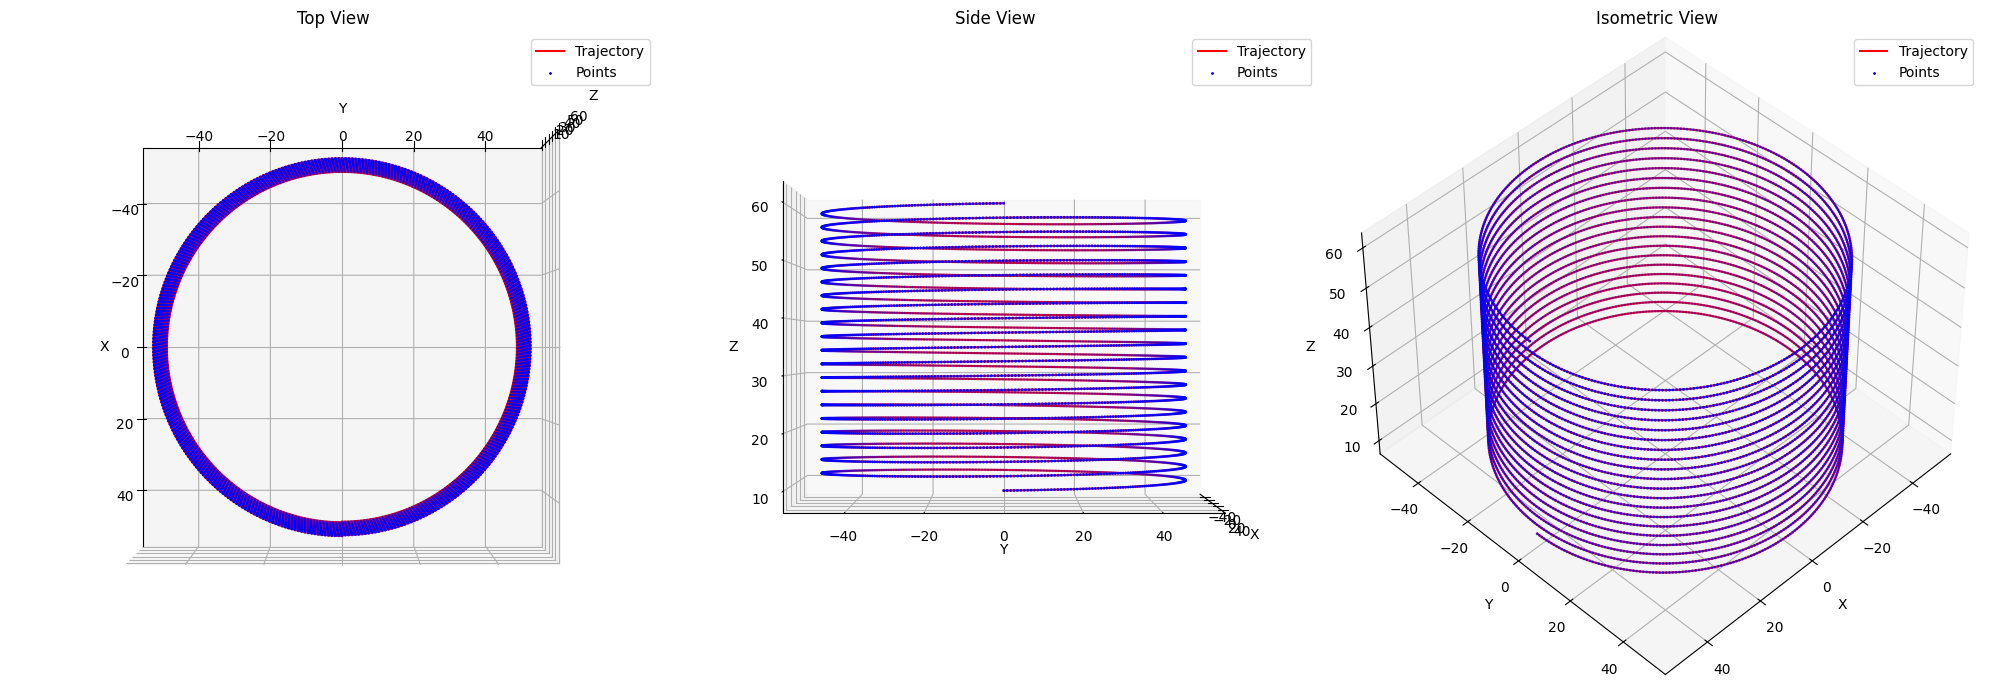

In [17]:
fig = plt.figure(figsize=(20, 8))

n_turns = 20
r_path = 0.5
base_points = 7000
    
center_pos = create_trajectory_3D("Helix", r_path*97, base_points, n_turns)
#print(center_pos)
    
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
ax1.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
ax1.view_init(elev=90, azim=0)  # Top view
ax1.set_title('Top View')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
    
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
ax2.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
ax2.view_init(elev=0, azim=0)  # Side view
ax2.set_title('Side View')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
    
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
ax3.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
ax3.view_init(elev=45, azim=45)  # Isometric view
ax3.set_title('Isometric View')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
for ax in [ax1, ax2, ax3]:
    ax.legend()
    
plt.show()